In [1]:
!pip install numpy==1.17.0
!pip install graphviz==0.9
!pip install pydot
!pip install seaborn==0.9.1

!apt-get install graphviz

  Using cached numpy-1.17.0-cp37-cp37m-manylinux1_x86_64.whl (20.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.17.0 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.17.0 which is incompatible.
pywavelets 1.3.0 requires numpy>=1.17.3, but you have numpy 1.17.0 which is incompatible.
pandas 1.3.5 requires numpy>=1.17.3; platform_machine != "aarch64" and platform_machine != "arm64" and python_version < "3.10", but you have numpy 1.17.0 which is incompatible.
kapre 0.3.7 requires numpy>=1.18.5, but you have numpy 1.17.0 which i

  Using cached numpy-1.21.5-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.17.0
    Uninstalling numpy-1.17.0:
      Successfully uninstalled numpy-1.17.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [2]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [3]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


Utilizando Dummy como linha de base

In [4]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


Rodar o DecisionTreeClassifier (em teoria mais inteligente que o Dummy) como uma segunda linha de base.

In [5]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


Cria uma coluna com variáveis categóricas de modelos, não para prever valor do carro. Dado que eu treino em diversos modelos de carro, quero saber quanto bom meu modelo será para treinar novos modelos de carro.

In [6]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [7]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [8]:
# GroupKFold em um pipeline com StandardScaler e SVC
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [9]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2) #Tamanho da árvore de decisão
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


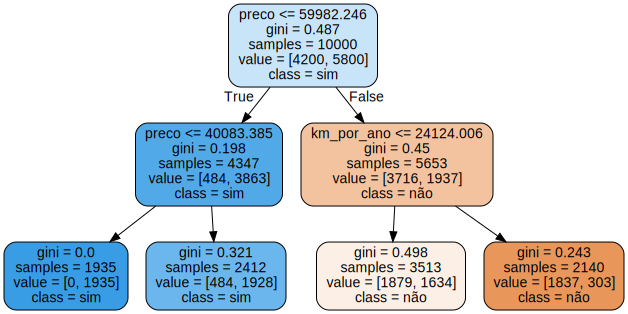

In [10]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

In [11]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67
Intervalo [76.40, 80.94]


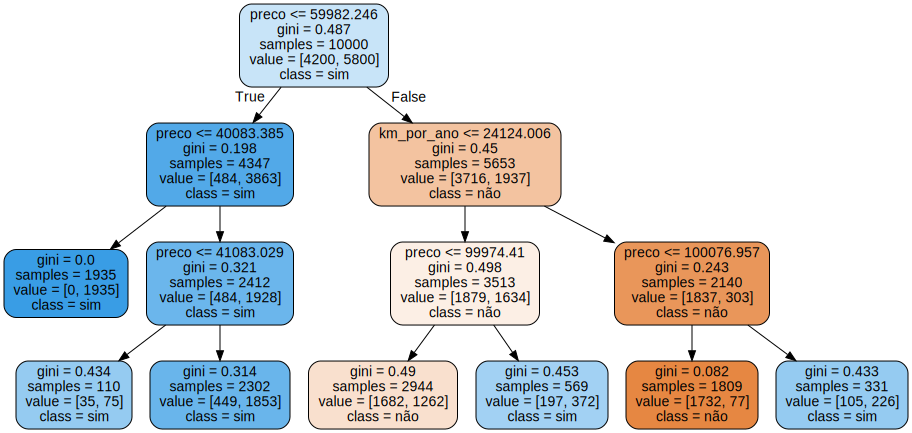

In [12]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

In [13]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=10)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 77.19
Intervalo [75.26, 79.13]


# Testando parâmetros

In [14]:
def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Arvore max_depth = %d, treino = %.2f, teste = %.2f" % (max_depth, train_score, test_score))
  tabela = [max_depth, train_score, test_score]
  return tabela
  
resultados = [roda_arvore_de_decisao(i) for i in range(1,33)]
resultados = pd.DataFrame(resultados, columns= ["max_depth","train","test"])
resultados.head()

Arvore max_depth = 1, treino = 75.79, teste = 75.78
Arvore max_depth = 2, treino = 75.79, teste = 75.78
Arvore max_depth = 3, treino = 78.75, teste = 78.67
Arvore max_depth = 4, treino = 78.79, teste = 78.63
Arvore max_depth = 5, treino = 78.94, teste = 78.56
Arvore max_depth = 6, treino = 79.17, teste = 78.12
Arvore max_depth = 7, treino = 79.50, teste = 77.96
Arvore max_depth = 8, treino = 79.89, teste = 77.86
Arvore max_depth = 9, treino = 80.46, teste = 77.38
Arvore max_depth = 10, treino = 81.16, teste = 77.19
Arvore max_depth = 11, treino = 82.03, teste = 76.97
Arvore max_depth = 12, treino = 82.89, teste = 76.49
Arvore max_depth = 13, treino = 83.95, teste = 75.81
Arvore max_depth = 14, treino = 85.03, teste = 75.66
Arvore max_depth = 15, treino = 86.14, teste = 75.16
Arvore max_depth = 16, treino = 87.19, teste = 75.11
Arvore max_depth = 17, treino = 88.31, teste = 74.74
Arvore max_depth = 18, treino = 89.26, teste = 74.33
Arvore max_depth = 19, treino = 90.32, teste = 74.34
Ar

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


# Bom no treino, ruim para o teste

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


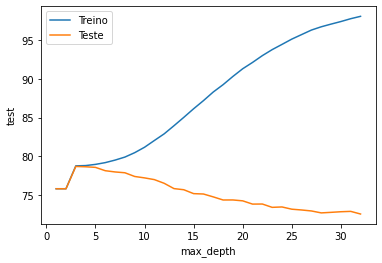

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)
plt.legend(["Treino", "Teste"])

Melhores resultados

In [16]:
resultados.sort_values("test", ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


Cuidado com a perfeição.

Em Decision Tree, existem samples, que são o números de elementos em uma folha. Não quero muito baixo, pois quero generalizar no mundo real. Gostaria de definir o mínimo de elementos de uma folha, por exemplo.

Agora temos dois valores para trabalhar.
max_depth = 1 -> min_samples -> 1;
max_depth = 1 -> min_samples -> 2;
.
.
.
max_depth = 64 -> min_samples -> 64.


In [17]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Arvore max_depth = %d, min_samples_leaf = %d, treino = %.2f, teste = %.2f" % (max_depth, min_samples_leaf, train_score, test_score))
  tabela = [max_depth, min_samples_leaf, train_score, test_score]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]: #Explorar apenas alguns valores
      tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
  return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 64, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Arvore max_depth = 4, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 

,max_depth,min_samples_leaf,train,test
0,1,32,75.791169,75.784219
1,1,64,75.791169,75.784219
2,1,128,75.791169,75.784219
3,1,256,75.791169,75.784219
4,2,32,75.791169,75.784219


In [18]:
resultados.sort_values("test", ascending=False).head() #Tabela de alguns melhores

,max_depth,min_samples_leaf,train,test
15,4,256,78.750993,78.672633
12,4,32,78.750993,78.672633
14,4,128,78.750993,78.672633
13,4,64,78.750993,78.672633
8,3,32,78.750993,78.672633


Como estão se comportando os valores de treino e teste de acordo max_depth e min_samples...

In [19]:
corr = resultados.corr()
corr
#Não é uma casualidade, porém pode ser um indicador.
#Quando max_depth cresce, max_depth cresce.
#Quando max_depth cresce, treino parece crescer.
#Quando mix_sample_leaf cresce, treino assume sentido oposto.

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,-2.780775e-16,0.536705,-0.027675
min_samples_leaf,-2.780775e-16,1.000000e+00,-0.409676,0.349011
train,5.367048e-01,-4.096762e-01,1.000000,0.116466
test,-2.767507e-02,3.490111e-01,0.116466,1.000000


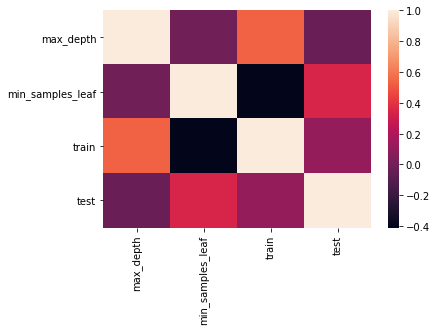

In [20]:
sns.heatmap(corr)
#Mapa de calor, claro (maior correlação), escuro (menor correlação)

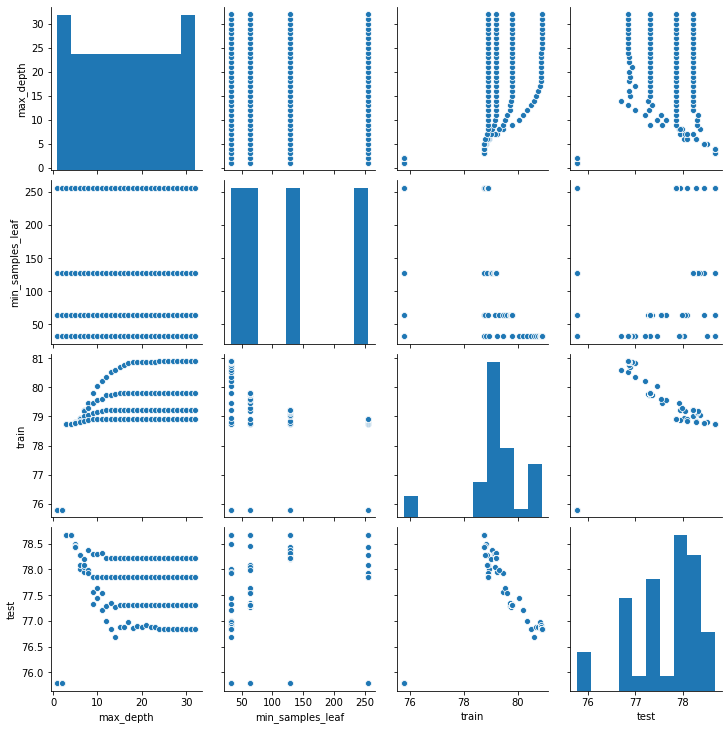

In [21]:
sns.pairplot(resultados)

# Histograma dos valores na diagonal
# max aumenta teste cai
# max aumenta treino sobe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


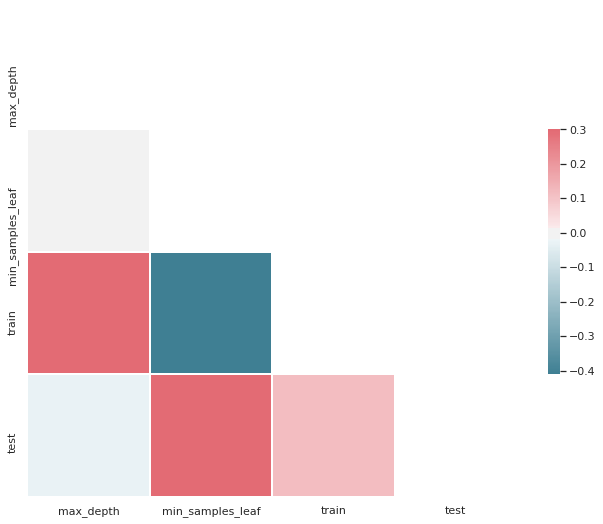

In [22]:
!pip install seaborn==0.9.1

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#min parece correlacionado com o teste, maior min -> maior qualidade do teste.
#Será que isso é verdade....

In [23]:
def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [128, 192, 256, 512]:
      tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
  return resultados

resultados = busca()
resultados.head()
#Não garente nada

Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 192, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 512, treino = 77.53, teste = 77.50
Arvore max_depth = 4, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_d

,max_depth,min_samples_leaf,train,test
0,1,128,75.791169,75.784219
1,1,192,75.791169,75.784219
2,1,256,75.791169,75.784219
3,1,512,75.791169,75.784219
4,2,128,75.791169,75.784219


In [24]:
corr = resultados.corr()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


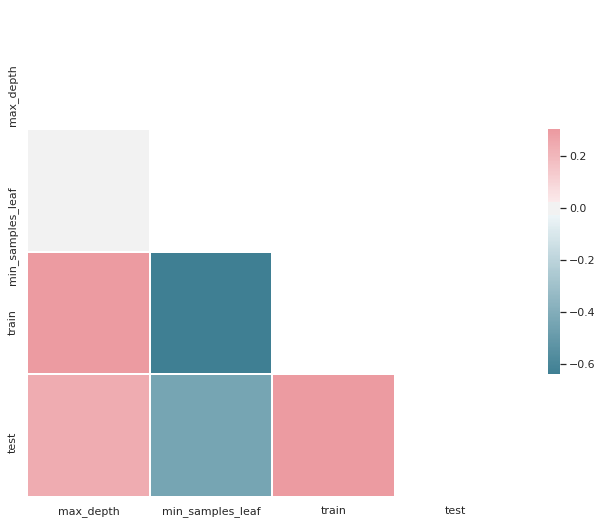

In [25]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [26]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
13,4,192,78.750993,78.672633
8,3,128,78.750993,78.672633
9,3,192,78.750993,78.672633
10,3,256,78.750993,78.672633
14,4,256,78.750993,78.672633


Qual mínimo de quebras para um split...

In [27]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  fit_time = results['fit_time'].mean()
  score_time = results['score_time'].mean()
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
      for min_samples_split in [32, 64, 128, 256]:
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","min_samples_split","train","test", "fit_time", "score_time"])
  return resultados

resultados = busca()
resultados.head()
#Tempo de treino e tempo de teste

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791169,75.784219,0.011760,0.004382
1,1,32,64,75.791169,75.784219,0.009101,0.003690
2,1,32,128,75.791169,75.784219,0.010469,0.004927
3,1,32,256,75.791169,75.784219,0.010086,0.003018
4,1,64,32,75.791169,75.784219,0.008933,0.003063


In [28]:
corr = resultados.corr()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


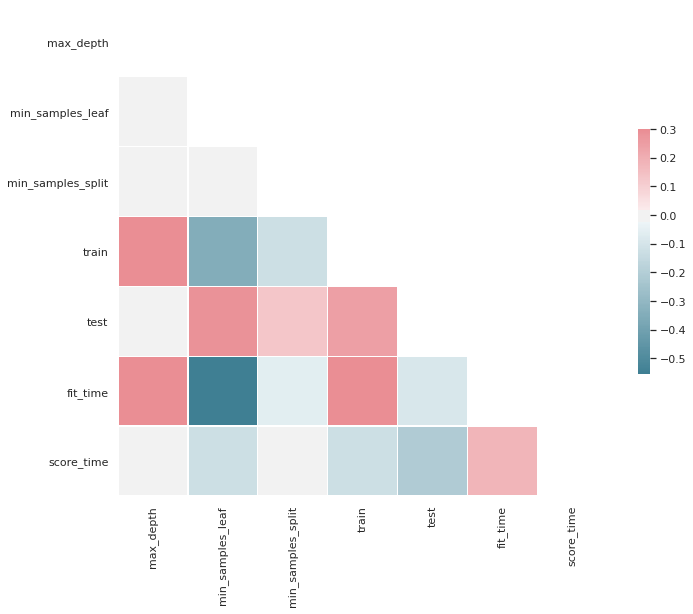

In [29]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [30]:
resultados.sort_values("test", ascending=False).head() #Melhorando nossa decisão

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
63,4,256,256,78.750993,78.672633,0.012381,0.001928
48,4,32,32,78.750993,78.672633,0.013137,0.002168
34,3,32,128,78.750993,78.672633,0.011171,0.002087
35,3,32,256,78.750993,78.672633,0.011189,0.001989
36,3,64,32,78.750993,78.672633,0.010801,0.001934


E com mais parâmetros... vamos utilizar o Grid...

In [31]:
from sklearn.model_selection import GridSearchCV

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = GroupKFold(n_splits = 10))
busca.fit(x_azar, y_azar, groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011907,0.001387,0.002219,0.000169,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.011259,0.000382,0.002206,0.000164,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.011169,0.000178,0.002236,0.000298,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.011315,0.000471,0.002210,0.000319,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.012515,0.001918,0.002486,0.000524,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [32]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [33]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

Como será que o melhor modelo vai se comportar...

In [34]:
from sklearn.metrics import accuracy_score

predicoes = melhor.predict(x_azar)
accuracy = accuracy_score(predicoes, y_azar) * 100
print("Accuracy para os dados foi %.2f%%" % accuracy)

Accuracy para os dados foi 78.75%


Parece que não ficou bom....

In [35]:
# Não seja otimista, faça outra cross validation (nested)

from sklearn.model_selection import GridSearchCV, KFold

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011410,0.001784,0.002523,0.000538,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.010804,0.000811,0.002235,0.000090,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.010412,0.000498,0.002263,0.000074,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.010192,0.000083,0.002722,0.001023,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.010127,0.000101,0.002190,0.000058,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [36]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

In [37]:
def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [38]:
imprime_score(scores)

Accuracy médio 78.67
Intervalo [76.80, 80.54]


In [39]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)


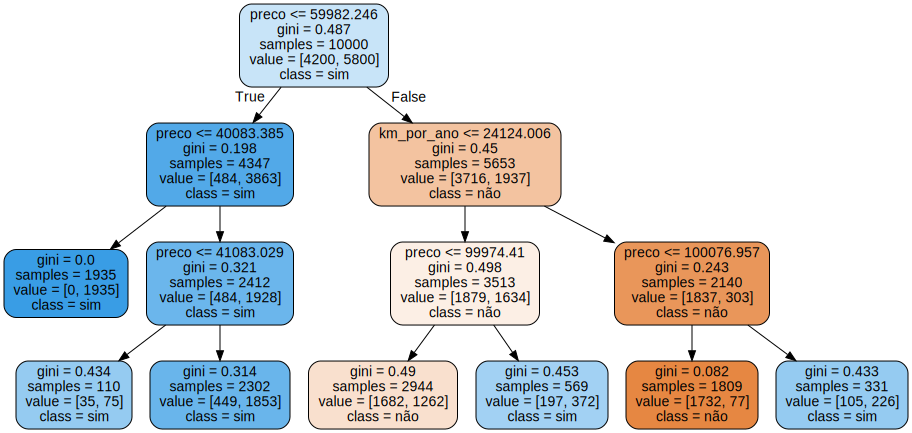

In [40]:
from sklearn.tree import export_graphviz
import graphviz

features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

Vamos tentar com o Random...

In [41]:
from sklearn.model_selection import RandomizedSearchCV

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    n_iter = 16, #iterações, depende dos dados
                    cv = KFold(n_splits = 5, shuffle=True),
                    random_state = SEED)
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.031875,0.011026,0.004291,0.000485,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.784,0.769,0.7985,0.793,0.7730,0.7835,0.011278,13
1,0.015054,0.000267,0.003900,0.000029,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
2,0.018103,0.004357,0.003964,0.000184,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
3,0.031309,0.002250,0.003935,0.000204,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7
4,0.024306,0.005106,0.002797,0.000645,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7


In [42]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores) #Passou perto

Accuracy médio 78.71
Intervalo [77.49, 79.93]


In [43]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=64)


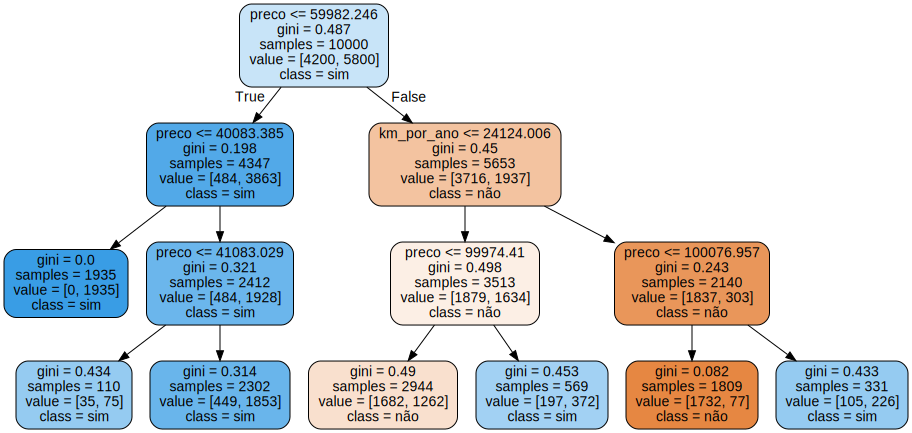

In [44]:
features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

Customizando o espaço de hiper parâmetros


In [45]:
from scipy.stats import randint

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None], #Customizando
    "min_samples_split" : randint(32, 128), #Devolve n quase aleatorios
    "min_samples_leaf" : randint(32, 128),
    "criterion" : ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    n_iter = 16, #iterações - amostras
                    cv = KFold(n_splits = 5, shuffle=True),
                    random_state = SEED)
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014370,0.001014,0.002180,0.000210,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.017689,0.000336,0.002264,0.000072,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,14
2,0.016437,0.000470,0.002249,0.000117,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,8
3,0.022287,0.001602,0.002387,0.000055,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,16
4,0.017904,0.001362,0.002463,0.000105,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,7


In [46]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)
#16 exemplos em um espaço 130000

Accuracy médio 78.71
Intervalo [77.49, 79.93]
DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=71,
                       min_samples_split=100)


In [47]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))
  #Ordenadado pelo score médio, desvio e parâmetros que geraram o resultado

0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.784 +-(0.024) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 73, 'min_samples_split': 72}
0.784 +-(0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.781 +-(0.017) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 108, 'min_samples_split': 110}
0.780 +-(0.019) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 125, 'min_samples_split': 59}
0.780 +-(0.012) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 103, 'min_samples_split': 96}
0.779 +-(0.021) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 126, 'min_samples_split': 84}
0.779 +-(0.020) {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 124, 'min_samples_split': 88}
0.779 +-(0.009) {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 101, 'min_samples_split': 52}
0.779 +-(0.014) {'criterion': 'entropy', 'max_depth

Será que consigo explorar mais...

In [51]:
from scipy.stats import randint

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None],
    "min_samples_split" : randint(32, 128),
    "min_samples_leaf" : randint(32, 128),
    "criterion" : ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    n_iter = 64,
                    cv = KFold(n_splits = 5, shuffle=True),
                    random_state = SEED)
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014853,0.001573,0.002401,0.000082,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.017946,0.000326,0.002390,0.000033,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,46
2,0.016833,0.000803,0.002372,0.000029,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,27
3,0.021613,0.001348,0.002579,0.000267,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,64
4,0.017184,0.000547,0.002668,0.000442,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,26


In [52]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))
  

0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.787 +-(0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 69, 'min_samples_split': 124}
0.787 +-(0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 63, 'min_samples_split': 88}
0.787 +-(0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 67, 'min_samples_split': 76}
0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 65, 'min_samples_split': 50}
0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 120, 'min_samples_split': 46}
0.787 +-(0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 53, 'min_samples_split': 111}
0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 106, 'min_samples_split': 108}
0.784 +-(0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.784 +-(0.024) {'criterion': 'gini', 'max_depth': 5, '

In [53]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

Accuracy médio 78.66
Intervalo [76.79, 80.53]
DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=71,
                       min_samples_split=100)


In [48]:
from scipy.stats import randint

SEED=564
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None],
    "min_samples_split" : randint(32, 128),
    "min_samples_leaf" : randint(32, 128),
    "criterion" : ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    n_iter = 64,
                    cv = KFold(n_splits = 5, shuffle=True),
                    random_state = SEED)
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.088844,0.030670,0.007301,0.004054,entropy,None,84,103,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.7780,0.7745,0.7735,0.7620,0.7625,0.7701,0.006583,62
1,0.017863,0.007825,0.005875,0.004165,gini,3,53,60,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7905,0.7855,0.7915,0.7905,0.7765,0.7869,0.005607,1
2,0.017004,0.000386,0.002399,0.000048,gini,30,118,61,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.7775,0.7745,0.7785,0.7720,0.7875,0.7780,0.005273,18
3,0.032177,0.001403,0.002553,0.000112,entropy,None,53,85,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.7710,0.7780,0.7760,0.7650,0.7655,0.7711,0.005295,57
4,0.019396,0.000167,0.002401,0.000011,gini,10,44,67,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.7755,0.7780,0.7835,0.7695,0.7735,0.7760,0.004669,29


In [49]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))
  

0.787 +-(0.011) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 33, 'min_samples_split': 77}
0.787 +-(0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 38, 'min_samples_split': 113}
0.787 +-(0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 53, 'min_samples_split': 60}
0.787 +-(0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 61, 'min_samples_split': 86}
0.787 +-(0.011) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 49, 'min_samples_split': 58}
0.787 +-(0.011) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 58, 'min_samples_split': 118}
0.787 +-(0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 122, 'min_samples_split': 117}
0.786 +-(0.013) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 39, 'min_samples_split': 73}
0.786 +-(0.013) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 45, 'min_samples_split': 65}
0.786 +-(0.014) {'criterion': 'entropy', 'max_depth': 5, 

In [50]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)
melhor = busca.best_estimator_
print(melhor) #Relativamente perto

Accuracy médio 78.69
Intervalo [77.64, 79.74]
DecisionTreeClassifier(max_depth=3, min_samples_leaf=53, min_samples_split=60)


Um breve comparativo

In [54]:
#Aqui utilizei o RandomForest
from sklearn.ensemble import RandomForestClassifier
import time

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : [10, 100], #n de arvores (estimadores)
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "bootstrap" : [True, False], #Treina uma parte do treino, posso pegar o mesmo elemento repetidamente ou não
    "criterion" : ["gini", "entropy"]
}

tic = time.time() #Existem funções melhores -> timeit
busca = GridSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 250.48 segundos


In [55]:
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.092473,0.026994,0.010815,0.004425,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7560,0.7490,0.7850,0.7450,0.7619,0.015357,130
1,0.662660,0.253127,0.054215,0.036791,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7655,0.7555,0.7945,0.7850,0.7625,0.7726,0.014685,93
2,0.041027,0.001855,0.005068,0.000079,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7780,0.7635,0.7835,0.7845,0.7560,0.7731,0.011373,89
3,0.379587,0.021356,0.029957,0.002970,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7425,0.7550,0.7950,0.7850,0.7620,0.7679,0.019356,119
4,0.038976,0.001936,0.005950,0.001644,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7405,0.7485,0.7760,0.7630,0.7607,0.014250,135


In [56]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))
  

0.780 +-(0.020) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.020) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
0.778 +-(0.030) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.027) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.033) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 100}


In [57]:
SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 20,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)


resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 36.66 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.452629,0.014345,0.027503,0.000375,100,32,128,3,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7740,0.7925,0.7775,0.7560,0.7742,0.011724,10
1,0.060772,0.002838,0.005479,0.000061,10,32,128,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.750,0.7785,0.7820,0.7785,0.7645,0.7707,0.011969,13
2,0.796493,0.229190,0.066002,0.069384,100,32,32,5,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7745,0.7930,0.7785,0.7585,0.7751,0.011178,6
3,0.044586,0.000705,0.005404,0.000066,10,128,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.750,0.7600,0.7450,0.7390,0.7520,0.7492,0.007026,20
4,0.061297,0.003391,0.005265,0.000146,10,64,32,3,entropy,False,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.771,0.7740,0.7635,0.7370,0.7585,0.7608,0.013094,18


In [58]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))
  

0.776 +-(0.025) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
0.776 +-(0.023) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 128, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
0.776 +-(0.024) {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
0.776 +-(0.032) {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}
0.775 +-(0.035) {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': True}


In [59]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

Tempo 146.90 segundos
Accuracy médio 77.59
Intervalo [76.47, 78.71]
RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=32,
                       min_samples_split=32)


In [60]:
SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" :randint(10, 101), #randit
    "max_depth" : randint(3, 6),
    "min_samples_split" : randint(32, 129),
    "min_samples_leaf" : randint(32, 129),
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 80,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)


resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 123.19 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.376655,0.008361,0.024610,0.000097,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7715,0.7620,0.7750,0.7855,0.7580,0.7704,0.009744,75
1,0.293673,0.005692,0.023251,0.001405,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7715,0.7575,0.7925,0.7855,0.7575,0.7729,0.014277,63
2,0.355722,0.084358,0.027164,0.006314,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7685,0.7695,0.7925,0.7795,0.7575,0.7735,0.011781,59
3,0.260950,0.063617,0.022865,0.006819,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7670,0.7830,0.7865,0.7580,0.7733,0.010429,60
4,0.425722,0.031744,0.035455,0.008504,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7685,0.7930,0.7850,0.7585,0.7754,0.012220,30


In [61]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))
  

0.779 +-(0.025) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 84, 'min_samples_split': 89, 'n_estimators': 48}
0.778 +-(0.031) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 96, 'n_estimators': 18}
0.778 +-(0.032) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 121, 'min_samples_split': 47, 'n_estimators': 27}
0.778 +-(0.024) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 96, 'min_samples_split': 98, 'n_estimators': 11}
0.777 +-(0.029) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 63, 'min_samples_split': 88, 'n_estimators': 69}


Caso não existe a possibilidade do cross validation

In [62]:
# 0.6 treino     => treino
# 0.2 teste      => dev teste
# 0.2 validacao  => validacao

from sklearn.model_selection import train_test_split

SEED=301
np.random.seed(SEED)
#80%
x_treino_teste, x_validacao, y_treino_teste, y_validacao = train_test_split(x_azar, y_azar, test_size=0.2, shuffle=True, stratify=y_azar)
print(x_treino_teste.shape) #8000 elementos para treinar e 3 colunas para treinar
print(x_validacao.shape)
print(y_treino_teste.shape)
print(y_validacao.shape)

(8000, 3)
(2000, 3)
(8000,)
(2000,)


In [63]:
from sklearn.model_selection import StratifiedShuffleSplit

espaco_de_parametros = {
    "n_estimators" :randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split" : randint(32, 129),
    "min_samples_leaf" : randint(32, 129),
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}
# 80% separada 25% para teste e 75% para treino, 20% separa 25% teste e 75% para treino
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25) #quebrar 1 vez e utilizar para treino e teste
# aleatorizar a ordem dos dados e quebrá-los de acordo com a estratificação dos dados que passarmos para ele

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 5,
                    cv = split)
busca.fit(x_treino_teste, y_treino_teste)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)


resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 1.10 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.092201,0.0,0.009424,0.0,True,gini,5,89,58,24,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7885,0.7885,0.0,3
1,0.139536,0.0,0.009757,0.0,False,entropy,3,71,55,27,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7920,0.7920,0.0,1
2,0.083101,0.0,0.007833,0.0,True,entropy,3,33,99,21,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.7910,0.7910,0.0,2
3,0.216005,0.0,0.019234,0.0,True,gini,3,98,100,67,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7785,0.7785,0.0,5
4,0.334068,0.0,0.019691,0.0,False,entropy,4,88,64,63,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7885,0.7885,0.0,3


In [64]:
tic = time.time()
scores = cross_val_score(busca, x_validacao, y_validacao, cv = split) #utilizando slit, não é o x azar, tão pouco y azar
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)
scores

Tempo 1.62 segundos


array([0.732])

Existe o Bayesian Search...